# Interpretability

In this section we discuss intepretability. We introduce several model-agnostic methods. 


Local: 
1. Individual Conditional Expectation (ICE) plots
2. Shapley Additive explanations (SHAP)

Global:
3. Partial Dependence Plots (PDPs)
4. ALE (Accumulated Local Effect) plots
5. Global SHAP values

We can also think of feature importances as interpretability methods. They are global and they don't necessarily correspond to averaging marginal effects or other metrics based on changes in predictions. Instead, feature importances are often based on differences in overall performance (as implied by names like Mean Decrease in Impurity). 

## What is interpretability? 

{cite}`molnar2020interpretable` surveys a few definitions and states one "model is more interpretable than another model if its decisions are easier for a human to understand than the other model’s decisions." 

Linear regression, logistic regression, and decision trees are all considered to be interpretable models. It might be worth noting that intepretable doesn't mean simple. Large decision trees don't have to be simple, but with a large enough printout, you can see the mechanics for why a tree predicts $\hat{y}$ when shown $\mathbf{x}$. As a social scientist, you might find this to answer an uninteresting "why" question. {cite}`mischell1989delay` uses an interpretable linear regression to analyze the marshmallow test experiment, predicting SAT scores from delay time. Waiting 15 minutes predicts a 117-point increase in the SAT quantitative score because the slope is 0.13. That is interpretation--a sort of mathematical audit. We are not explaining the phenomenon. 



In [ ]:
# Matplotlib: two-panel 3D Gabor surface, plus rotated view with true PDP_x overlay
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- Gabor parameters (same as before) ---
theta = 0.8
lam = 0.75
sigma = 1.0
gamma = 0.7
phi = 0.3
bounds = (-3.0, 3.0)

ct, st = np.cos(theta), np.sin(theta)

def gabor2d_grid(X, Y):
    x_p =  X * ct + Y * st
    y_p = -X * st + Y * ct
    gauss = np.exp(-(x_p**2 + (gamma**2) * y_p**2) / (2 * sigma**2))
    carrier = np.cos(2 * np.pi * x_p / lam + phi)
    return gauss * carrier

def gabor_line_x(x, y0):
    x_p =  x * ct + y0 * st
    y_p = -x * st + y0 * ct
    gauss = np.exp(-(x_p**2 + (gamma**2) * y_p**2) / (2 * sigma**2))
    carrier = np.cos(2 * np.pi * x_p / lam + phi)
    return gauss * carrier

# --- Grid and surface values ---
N = 250
x = np.linspace(bounds[0], bounds[1], N)
y = np.linspace(bounds[0], bounds[1], N)
X, Y = np.meshgrid(x, y)
Z = gabor2d_grid(X, Y)

# True PDP_x under a uniform Y over [bounds]: average Z over Y axis
pdp_x = Z.mean(axis=0)      # shape (N,)
slice_y0 = gabor_line_x(x, 0.0)

# --- Plot ---
fig = plt.figure(figsize=(12, 5))

# Panel A: normal angled 3D view
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=0, antialiased=True)
ax1.set_title("Gabor surface g(x, y)")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("g(x, y)")
ax1.view_init(elev=30, azim=45)

# Panel B: rotate to look along y; overlay true PDP_x and a y=0 slice
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=0, antialiased=True, alpha=0.0)
ax2.view_init(elev=0, azim=-90)  # look along +y so the panel reads as (x, g(x,y))
ax2.set_title("Rotated view (along y) with PDP$_x$ and slice y=0")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("g(x, y)")

# Put the PDP line at the front edge (y = y.min()) and the y=0 slice in the middle
ax2.plot(x, np.full_like(x, y.min()), pdp_x, lw=3, label="True PDP$_x$ (avg over y)")
ax2.plot(x, np.full_like(x, 0.0), slice_y0, lw=1.5, ls="--", label="Slice y=0")

ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()


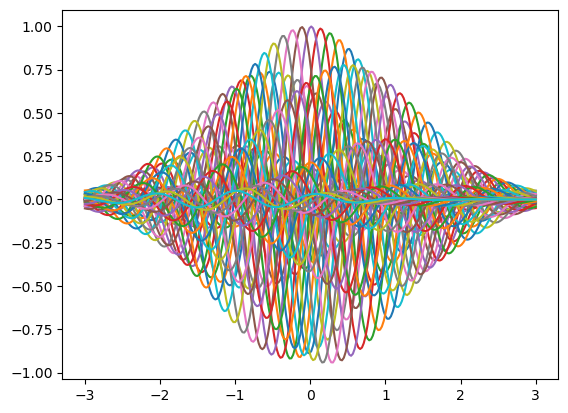

In [20]:
for y in np.linspace(-3,3):

    plt.plot(x, gabor_line_x(x, y), label=f"{y:.2f}")

#plt.legend()

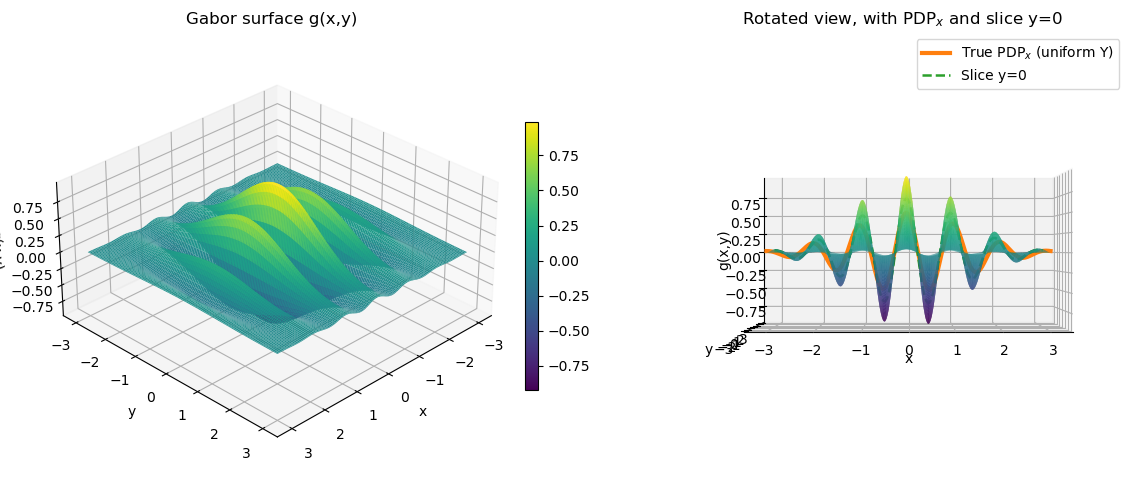

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib import cm

# ---- Parameters chosen for clear PDP_x ----
theta = 0.0     # axis-aligned so PDP_x is informative
lam = 1.0
sigma = 1.2
gamma = 1.0
phi = 0.3
bounds = (-3.0, 3.0)
N = 250

ct, st = np.cos(theta), np.sin(theta)

def gabor2d_grid(X, Y):
    x_p =  X*ct + Y*st
    y_p = -X*st + Y*ct
    gauss = np.exp(-(x_p**2 + (gamma**2)*y_p**2) / (2*sigma**2))
    carrier = np.cos(2*np.pi*x_p/lam + phi)
    return gauss * carrier

def gabor_line_x(x, y0):
    x_p =  x * ct + y0 * st
    y_p = -x * st + y0 * ct
    gauss = np.exp(-(x_p**2 + (gamma**2) * y_p**2) / (2 * sigma**2))
    carrier = np.cos(2 * np.pi * x_p / lam + phi)
    return gauss * carrier

# Grid and values
x = np.linspace(bounds[0], bounds[1], N)
y = np.linspace(bounds[0], bounds[1], N)
X, Y = np.meshgrid(x, y)
Z = gabor2d_grid(X, Y)

# True PDP_x under uniform Y over [bounds]: average across Y
pdp_x = Z.mean(axis=0)


slice_y0 = gabor_line_x(x, y0=1) # gabor2d_grid(x[None, :], np.zeros((1, len(x)))).ravel()

# ---- Plot ----
fig = plt.figure(figsize=(12, 5))

# Panel A: angled view
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(X, Y, Z, rstride=2, cstride=2, linewidth=0,
                        cmap=cm.viridis, antialiased=True)
ax1.set_box_aspect((1,1,0.5))
ax1.view_init(elev=30, azim=45)
ax1.set_title("Gabor surface g(x,y)")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("g(x,y)")
fig.colorbar(surf, ax=ax1, shrink=0.6, pad=0.05)

# Panel B: rotate to look along y; overlay PDP_x and y=0 slice
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, Z, rstride=2, cstride=2, linewidth=0,
                 cmap=cm.viridis, alpha=0.9, antialiased=True)
ax2.view_init(elev=0, azim=-90)  # look along y
ax2.set_box_aspect((1,1,0.5))
ax2.set_title("Rotated view, with PDP$_x$ and slice y=0")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("g(x,y)")

# Put PDP at front edge y=y.min() and a mid-plane slice at y=0
ax2.plot(x, np.full_like(x, y.min()), pdp_x, lw=3, label="True PDP$_x$ (uniform Y)")
ax2.plot(x, np.full_like(x, 0.0), slice_y0, lw=1.8, ls="--", label="Slice y=0")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


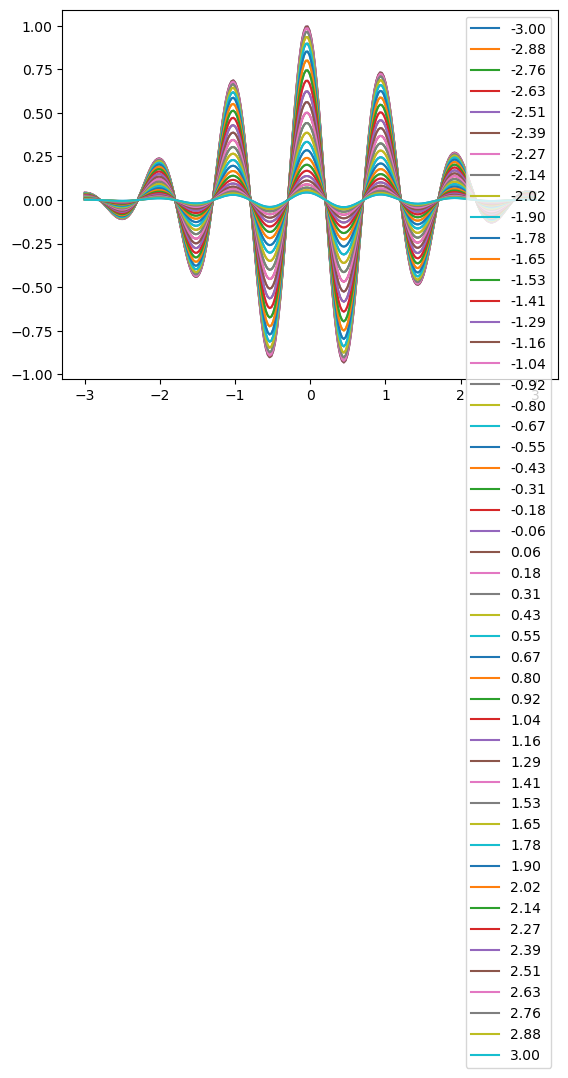

In [17]:
for y in np.linspace(-3,3):

    plt.plot(x, gabor_line_x(x, y), label=f"{y:.2f}")

plt.legend()

# Shapley Values

Shapley values originate in cooperative game theory and not in machine learning. A cooperative game is defined by a set of players $N$ and a characteristic funtion $v$ which defines the value of a coalition, $v: 2^N \rightarrow \mathbb{R}$. The Shapley value for a player $i$ is calculated as 

$$ \phi_i = \sum_{S\subseteq N\setminus\{i\}} \frac{ |S|! \times (|N|-|S|-1)! }{|N|!} \times \left[ v(S\cup\{i\}) - v(S)\right].$$

Shapley values have a number of nice properties. Two I will highlight are efficiency and symmetry. 

**Efficiency**:  $\sum_i \phi_i = v(N)-v(\emptyset)$

**Symmetry**: If, for $i,j\in N$, $v(S \cup \{i\}) = v(S \cup \{j\})$ for all $S\subseteq N \setminus \{i,j\}$, then $\phi_j = \phi_i$.

Shapley values are a sort of a priori measure of a player's value in a game. They don't correspond to treatment effects or a posteriori measures of pivotality. 

## Examples

### Majority Rule
Suppose that there are three players in a majority-rule voting game. $v(S)$ is 1 if $\vert S \vert \geq 2$. If $\vert S \vert < 2$, then $v(S)=0$. 

By efficiency, the Shapley values sum to 1. By symmetry, they are all equal. Therefore, the Shapley values are each $\frac{1}{3}$. 

### Simplified Electoral College
Suppose that there are three states (players) with electoral votes 10, 10, and 19. $v(S)$ is 1 if the electoral votes sum to 20 or more. Otherwise, $v(S)=0$. The electoral votes don't actually mean anything--this reduces to a simple majority rule game. Therefore, the Shapley values are each $\frac{1}{3}$. 

### Sharks and Minnows

Buzz is shopping for fish. He may buy any subset of {shark 1, shark 2, minnow 1, minnow 2}. The characteristic function measures how many fish will be in the tank after enough time. ANy two fish of the same kind reproduce once. A shark eats any minnows in the same tank. 

There are four players and thus 4! orderings. For minnow 1: 

* Minnow 1 is first in 6/24 orders. The marginal value is 1.
* Minnow 2 preceds minnow 1 as the first element in 2/24 orders. The marginal value is 2.
* Otherwise, minnow 1 is preceded by a shark. The marginal value is 0.

Therefore, $v(\text{minnow 1}) = \frac{6}{24} 1 + \frac{2}{24}2 = \frac{5}{12}.$